Created By: Tanisha Shrotriya

# Task 2 - Pipeline + Unit Testing 

## Pre-requisite: Library requirements

In [1]:
# # !nvidia-smi
%pip install numpy
%pip install matplotlib
%pip install glob
%pip install os 
%pip install sklearn
%pip install -U scikit-learn scipy matplotlib scikit-image
%pip install opencv-python
%pip install kmeanstf
%pip install keract
%pip install -U scikit-learn scipy matplotlib
%pip install opencv-python
%pip install kmeanstf
%pip install pandas

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement glob (from versions: none)
ERROR: No matching distribution found for glob
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting

Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable


Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
#!nvidia-smi
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import glob
import os


## Data Pre-processing 
### 1. Extract data into numpy arrays called - frac_map and time_series

- Each fraction map is of shape (1,64,64) and time series is of shape (442,1)
- There are 26754 data in total in fraction map and time series

In [3]:
fracmaps_dir = '../data/frac_map'
frac_maps = os.listdir(fracmaps_dir)
timeseries_dir = '../data/time_series'
time_series = os.listdir(timeseries_dir)

total_maps = len(frac_maps) # 26754
total_ts = len(time_series) # 26754
print("total_maps len is ", total_maps, "total_ts len is ", total_ts)

## read fraction map and time series into img arrays
for i in range(0, total_maps):
    fm = frac_maps[i]
    frac_maps[i] = np.load(os.path.join(fracmaps_dir, fm), allow_pickle=True)
    ts = time_series[i]
    time_series[i] = np.load(os.path.join(timeseries_dir, ts), allow_pickle=True)
    

print(frac_maps[0].shape) ## (1,64,64)
print(time_series[0].shape) ## (442, 1)

total_maps len is  26754 total_ts len is  26754
(1, 64, 64)
(442, 1)


### 2. Read all the river fraction maps in the fm_rivers and river time series in the ts_rivers array

In [4]:
ID_labels = '../label_info/all_IDs_labels.npy'
ID_labels = np.load(ID_labels, allow_pickle=True)

# extract river from fraction maps and time series maps
river_ids = np.where(ID_labels==3)[0]
print(river_ids.shape) # 317
fm_rivers = []
ts_rivers = []
pre = 'ID_'
fm_post = '_frac_map.npy'
ts_post = '_time_series.npy'

for sid in river_ids:
    fm_name = pre + str(sid) + fm_post
    ts_name = pre + str(sid) + ts_post
    fm_path = os.path.join(fracmaps_dir, fm_name)
    ts_path = os.path.join(timeseries_dir, ts_name)
    fm_rivers.append(np.load(fm_path, allow_pickle=True))
    ts_rivers.append(np.load(ts_path, allow_pickle=True))

fm_rivers = np.array(fm_rivers)
ts_rivers = np.array(ts_rivers)
print(fm_rivers.shape) # should be 317
print(ts_rivers.shape) # should be 317

(317,)
(317, 1, 64, 64)
(317, 442, 1)


# Unsupervised Curriculum Learning

### Reshape input dataset as required by resnet50v2

In [5]:
import cv2
from skimage.transform import resize
im = np.reshape(fm_rivers,(317,64,64,1))
im = resize(im, (317,64,64,3))
im.shape

(317, 64, 64, 3)

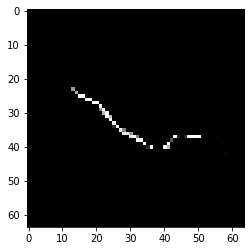

In [6]:
plt.imshow(im[0])
plt.show()

In [7]:
X_train =im
type(X_train)
X_train[0].shape

(64, 64, 3)

### Step 1  :
Extract features of remote sensing imagery of water bodies and non-water bodies using a pre-trained deep learning architecture.

In [8]:
from tensorflow.keras.layers import Flatten, Dense, Input, Lambda, Conv2D, MaxPooling2D
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img,ImageDataGenerator, img_to_array
import tensorflow as tf

import numpy as np
from glob import glob
import os
import matplotlib.pyplot as plt 

2022-12-19 06:57:06.587370: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-19 06:57:06.728578: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /panfs/jay/groups/6/csci8523/shrot007/.local/lib/python3.7/site-packages/cv2/../../lib64:/panfs/roc/msisoft/cuda/10.0/lib64
2022-12-19 06:57:06.728615: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-19 06:57:08.055603: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:6

In [9]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Sequential

resnet = ResNet50(include_top=False, pooling='avg', weights='imagenet',input_shape = (64,64,3),classes = 1)

# ResNet model doesn't contain the flattened fully connected layers, so we add them separately.
resnet.layers

2022-12-19 06:57:10.525989: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /panfs/jay/groups/6/csci8523/shrot007/.local/lib/python3.7/site-packages/cv2/../../lib64:/panfs/roc/msisoft/cuda/10.0/lib64
2022-12-19 06:57:10.526039: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-19 06:57:10.526080: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (acn01): /proc/driver/nvidia/version does not exist
2022-12-19 06:57:10.526305: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other oper

In [10]:
# ResNet model doesn't contain the flattened fully connected layers, so we add them separately.
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 16, 16, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 16, 16, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 16, 16, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_block3_3_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv2_block3_3_conv[0][0]']    
 ization) 

                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 8, 8, 128)   512         ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 8, 8, 128)   0           ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 8, 8, 512)    66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_block3_3_bn (BatchNormal  (None, 8, 8, 512)   2048        ['conv3_block3_3_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 4, 4, 256)   1024        ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 4, 4, 256)   0           ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 4, 4, 1024)   263168      ['conv4_block2_2_relu[0][0]']    
                                                                                                  
 conv4_block2_3_bn (BatchNormal  (None, 4, 4, 1024)  4096        ['conv4_block2_3_conv[0][0]']    
 ization) 

 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 4, 4, 1024)   263168      ['conv4_block5_2_relu[0][0]']    
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 4, 4, 1024)  4096        ['conv4_block5_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_add (Add)         (None, 4, 4, 1024)   0           ['conv4_block4_out[0][0]',       
                                                                  'conv4_block5_3_bn[0][0]']      
                                                                                                  
 conv4_blo

 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 2, 2, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 2, 2, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 2, 2, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
                                                                                                  
 conv5_blo

In [11]:
resnet.layers[-1].output

<KerasTensor: shape=(None, 2048) dtype=float32 (created by layer 'avg_pool')>

In [12]:
# ResNet model doesn't contain the flattened fully connected layers, so we add them separately.
ucl_model = Sequential()
ucl_model.add(resnet)
ucl_model.add(Flatten())
ucl_model.add(Dense(128, activation='relu'))
ucl_model.add(Dense(1, activation='sigmoid')) #sigmoid is used because this is a binary classification.  

In [13]:
ucl_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 23,850,113
Trainable params: 23,796,993
Non-trainable params: 53,120
_________________________________________________________________


In [14]:
# freeze resnet50 conv layers and keep only new layers for fine-tuning. 
ucl_model.layers[0].trainable = False
ucl_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 23,850,113
Trainable params: 262,401
Non-trainable params: 23,587,712
_________________________________________________________________


In [15]:
resnet_classes = ucl_model.predict(X_train)

10/10 [==============================] - 2s 170ms/step


In [16]:
# classification results for binary classification of rivers, using imagenet weights
resnet_classes

array([[0.45148402],
       [0.46632734],
       [0.46258864],
       [0.46671104],
       [0.47318426],
       [0.48132706],
       [0.4735146 ],
       [0.4747016 ],
       [0.46858126],
       [0.4724218 ],
       [0.51836467],
       [0.48465082],
       [0.46037892],
       [0.49496675],
       [0.45505756],
       [0.45461547],
       [0.4741769 ],
       [0.467489  ],
       [0.4621747 ],
       [0.44642907],
       [0.47140673],
       [0.4660335 ],
       [0.47261977],
       [0.4732953 ],
       [0.5061099 ],
       [0.45292976],
       [0.46327952],
       [0.4745422 ],
       [0.49701497],
       [0.50456834],
       [0.4647314 ],
       [0.49415654],
       [0.49194705],
       [0.46399805],
       [0.46184444],
       [0.47097862],
       [0.4672249 ],
       [0.46144235],
       [0.4803284 ],
       [0.46192935],
       [0.47320953],
       [0.45835832],
       [0.5017411 ],
       [0.4523494 ],
       [0.4688304 ],
       [0.45957133],
       [0.45156673],
       [0.466

### Step 2:
Create two clusters on the extracted features of remote sensing imagery, assigning them pseudo-labels of 'static rivers' and 'may meander rivers'

### Kmeans

The images are classified into clusters based on similarity of pixel values. Each image is assigned a cluster label value given by kmeans.labels_. So kmeans.labels_ is an array of length 26754 as there are 26754 images in the training set.

In [17]:
# The input to kmeans comes from the following layer which have imagenet weights after step 1.
print("Layer type: ", ucl_model.layers[-3])
print("Layer details: ",ucl_model.layers[-3].output)

Layer type:  <keras.layers.reshaping.flatten.Flatten object at 0x7f7e904dc310>
Layer details:  KerasTensor(type_spec=TensorSpec(shape=(None, 2048), dtype=tf.float32, name=None), name='flatten/Reshape:0', description="created by layer 'flatten'")


In [18]:
ucl_model.inputs

[<KerasTensor: shape=(None, 64, 64, 3) dtype=float32 (created by layer 'resnet50_input')>]

In [19]:
# create a new model to extract the features from ucl_model. This is the actual input to kmeans.
from keras.models import Model

model_features= Model(inputs=ucl_model.inputs, outputs=ucl_model.layers[-3].output)
features = model_features.predict(X_train)  

10/10 [==============================] - 2s 163ms/step


In [20]:
features.shape[0]

317

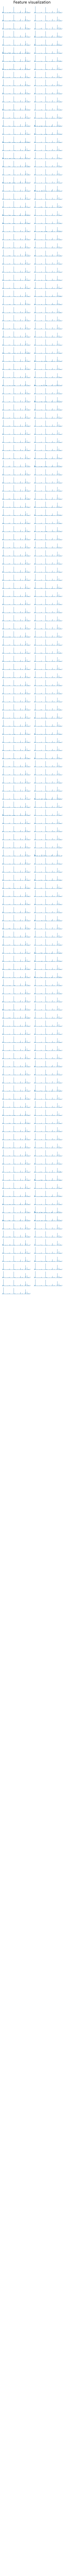

In [21]:
fig, axes = plt.subplots(317,2, figsize=(10, 400))
fig.suptitle('Feature visualization',y=1.0,fontsize=40,ha='center')
ax = axes.ravel()
for i in range(0,features.shape[0]):
    river_array = features[i]
    ax[i].plot(river_array)
    
for a in ax:
        a.set_axis_off()
plt.tight_layout()
plt.show()   

In [22]:
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.utils import shuffle
import re
import cv2
from kmeanstf import KMeansTF

In [23]:
#Import required module
from sklearn.cluster import KMeans
 
#Initialize the class object
kmeans = KMeans(n_clusters= 2)
 
#Fit kmeans to the labels of clusters.
kmeans = kmeans.fit(features)
 
print(np.unique(kmeans))

[KMeans(n_clusters=2)]


In [24]:
print(kmeans.labels_)
print(len(kmeans.labels_))
kmeans.cluster_centers_

[1 0 1 0 1 0 0 1 0 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 0 1
 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0
 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0
 0 1 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0]
317


array([[0.        , 0.        , 0.11341354, ..., 1.8035023 , 0.        ,
        0.        ],
       [0.        , 0.        , 0.06798159, ..., 1.9113446 , 0.        ,
        0.        ]], dtype=float32)

Total number of rivers in cluster 0:  (256, 2048)
Total number of rivers in cluster 1:  (61, 2048)


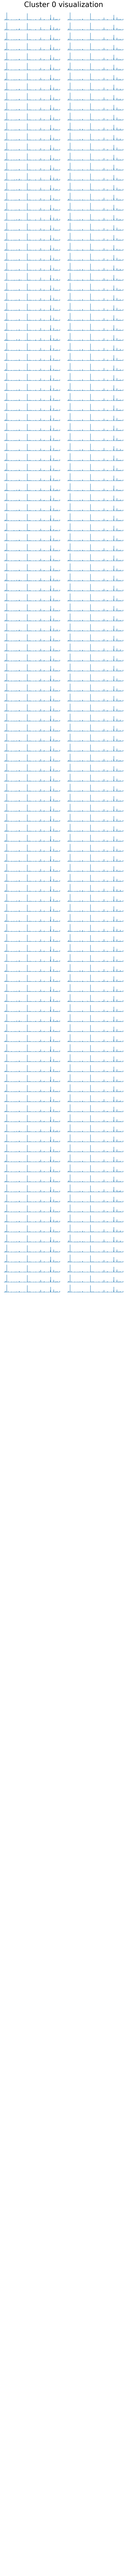

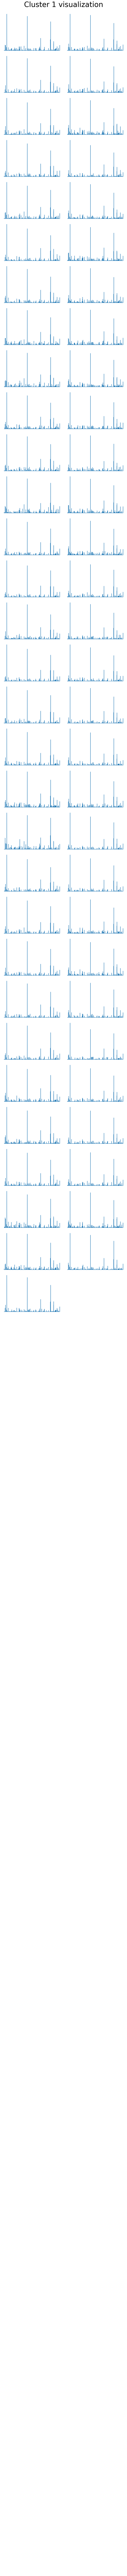

In [25]:
# visualize the clusters
import matplotlib.pyplot as plt
 
# filter rows of original data
labels0 = features[kmeans.labels_ == 0]
labels1 = features[kmeans.labels_ == 1]
print("Total number of rivers in cluster 0: ",labels0.shape) 
print("Total number of rivers in cluster 1: ",labels1.shape) 

fig1, axes1 = plt.subplots(len(labels0),2, figsize=(10, 200))
fig1.suptitle('Cluster 0 visualization',y=1.0,fontsize=40,ha='center')
ax1 = axes1.ravel()
for i in range(0,len(labels0)):
    river_array = labels0[i]
    ax1[i].plot(river_array)

for a in ax1:
        a.set_axis_off()
plt.tight_layout()
plt.show()   
    
fig2, axes2 = plt.subplots(len(labels1),2, figsize=(10, 200))
fig2.suptitle('Cluster 1 visualization',y=1.0,fontsize=40,ha='center')
ax2 = axes2.ravel()
for i in range(0,len(labels1)):
    river_array = labels1[i]
    ax2[i].plot(river_array)

for a in ax2:
        a.set_axis_off()
plt.tight_layout()
plt.show()   
    

### Step 3 : 

From each cluster, select the reliable images using the UCL based selection operation. 

Select all features that are at a distance λ from the centroid of the cluster. The parameter λ is a constant value 
that can be adjusted according to the requirement. We have used λ = 0.85 after empirical evaluations.  
The closest feature vector to the centroid is considered as a centroid feature vector. 

We calculate the similarity between a specific feature vector fi belonging to a cluster k and the centroid feature vector fk using the inner product. 

If the calculated similarity is greater than the λ, the sample of the considered feature vector is declared as a reliable sample and the cluster label is considered as the pseudo sample label for the next training cycle.  

The number of extracted reliable samples vary at every iteration of fine tuning. 

In [26]:
from numpy.linalg import norm

In [27]:
# cluster centroids 
centers = kmeans.cluster_centers_

# calculate cosine similarity 
dot_product = np.dot(centers[0],labels0.T) #(1,2048).(2048,len(labels0))
normalize_product = norm(centers[0])*norm(labels0,axis=1)
features_center_1 = dot_product/normalize_product

print("Similarity to centroid 1 :\n\n",features_center_1)

# calculate cosine similarity 
dot_product = np.dot(centers[1],labels1.T) #(1,2048).(2048,len(labels1))
normalize_product = norm(centers[1])*norm(labels1,axis=1)
features_center_2 = dot_product/normalize_product

print("\n")
print("Similarity to centroid 2 : \n\n",features_center_2)

Similarity to centroid 1 :

 [0.9985565  0.9990809  0.9918755  0.9957142  0.9983994  0.9953899
 0.99820256 0.9977211  0.9990873  0.99810225 0.99677557 0.9961474
 0.99743176 0.9985817  0.9986254  0.99545777 0.9993581  0.9960397
 0.9990143  0.9994542  0.999409   0.9985707  0.9984583  0.99367845
 0.9995879  0.99641275 0.9991418  0.9979895  0.998507   0.99815744
 0.9993202  0.99515903 0.9898346  0.9993004  0.9965924  0.9984517
 0.99890226 0.9960741  0.9983459  0.99652463 0.9914708  0.9962683
 0.9983696  0.9990681  0.9986273  0.99814117 0.9991686  0.9927583
 0.9994324  0.99894845 0.9991264  0.9960157  0.99256146 0.9945128
 0.99872816 0.9987258  0.9991     0.99927694 0.9991708  0.9991587
 0.99846244 0.9979684  0.99877506 0.9981733  0.9910138  0.9991755
 0.9981596  0.9962492  0.9990361  0.9982905  0.99550134 0.9984588
 0.99903405 0.9991095  0.99829596 0.99647    0.99949944 0.99887866
 0.9983853  0.99874943 0.9987552  0.9983842  0.99923235 0.99923104
 0.99920547 0.9988014  0.99883443 0.987122 

In [28]:
training_class1 = features_center_1[features_center_1 >= 0.995]
training_class2 = features_center_2[features_center_2 >= 0.995]

print("Total features selected for centroid 1: ",training_class1.shape)
print("Total features selected for centroid 2: ",training_class2.shape)

Total features selected for centroid 1:  (239,)
Total features selected for centroid 2:  (33,)


Below is probably the most complicated cell in this entire notebook. Please read explanation with patience -
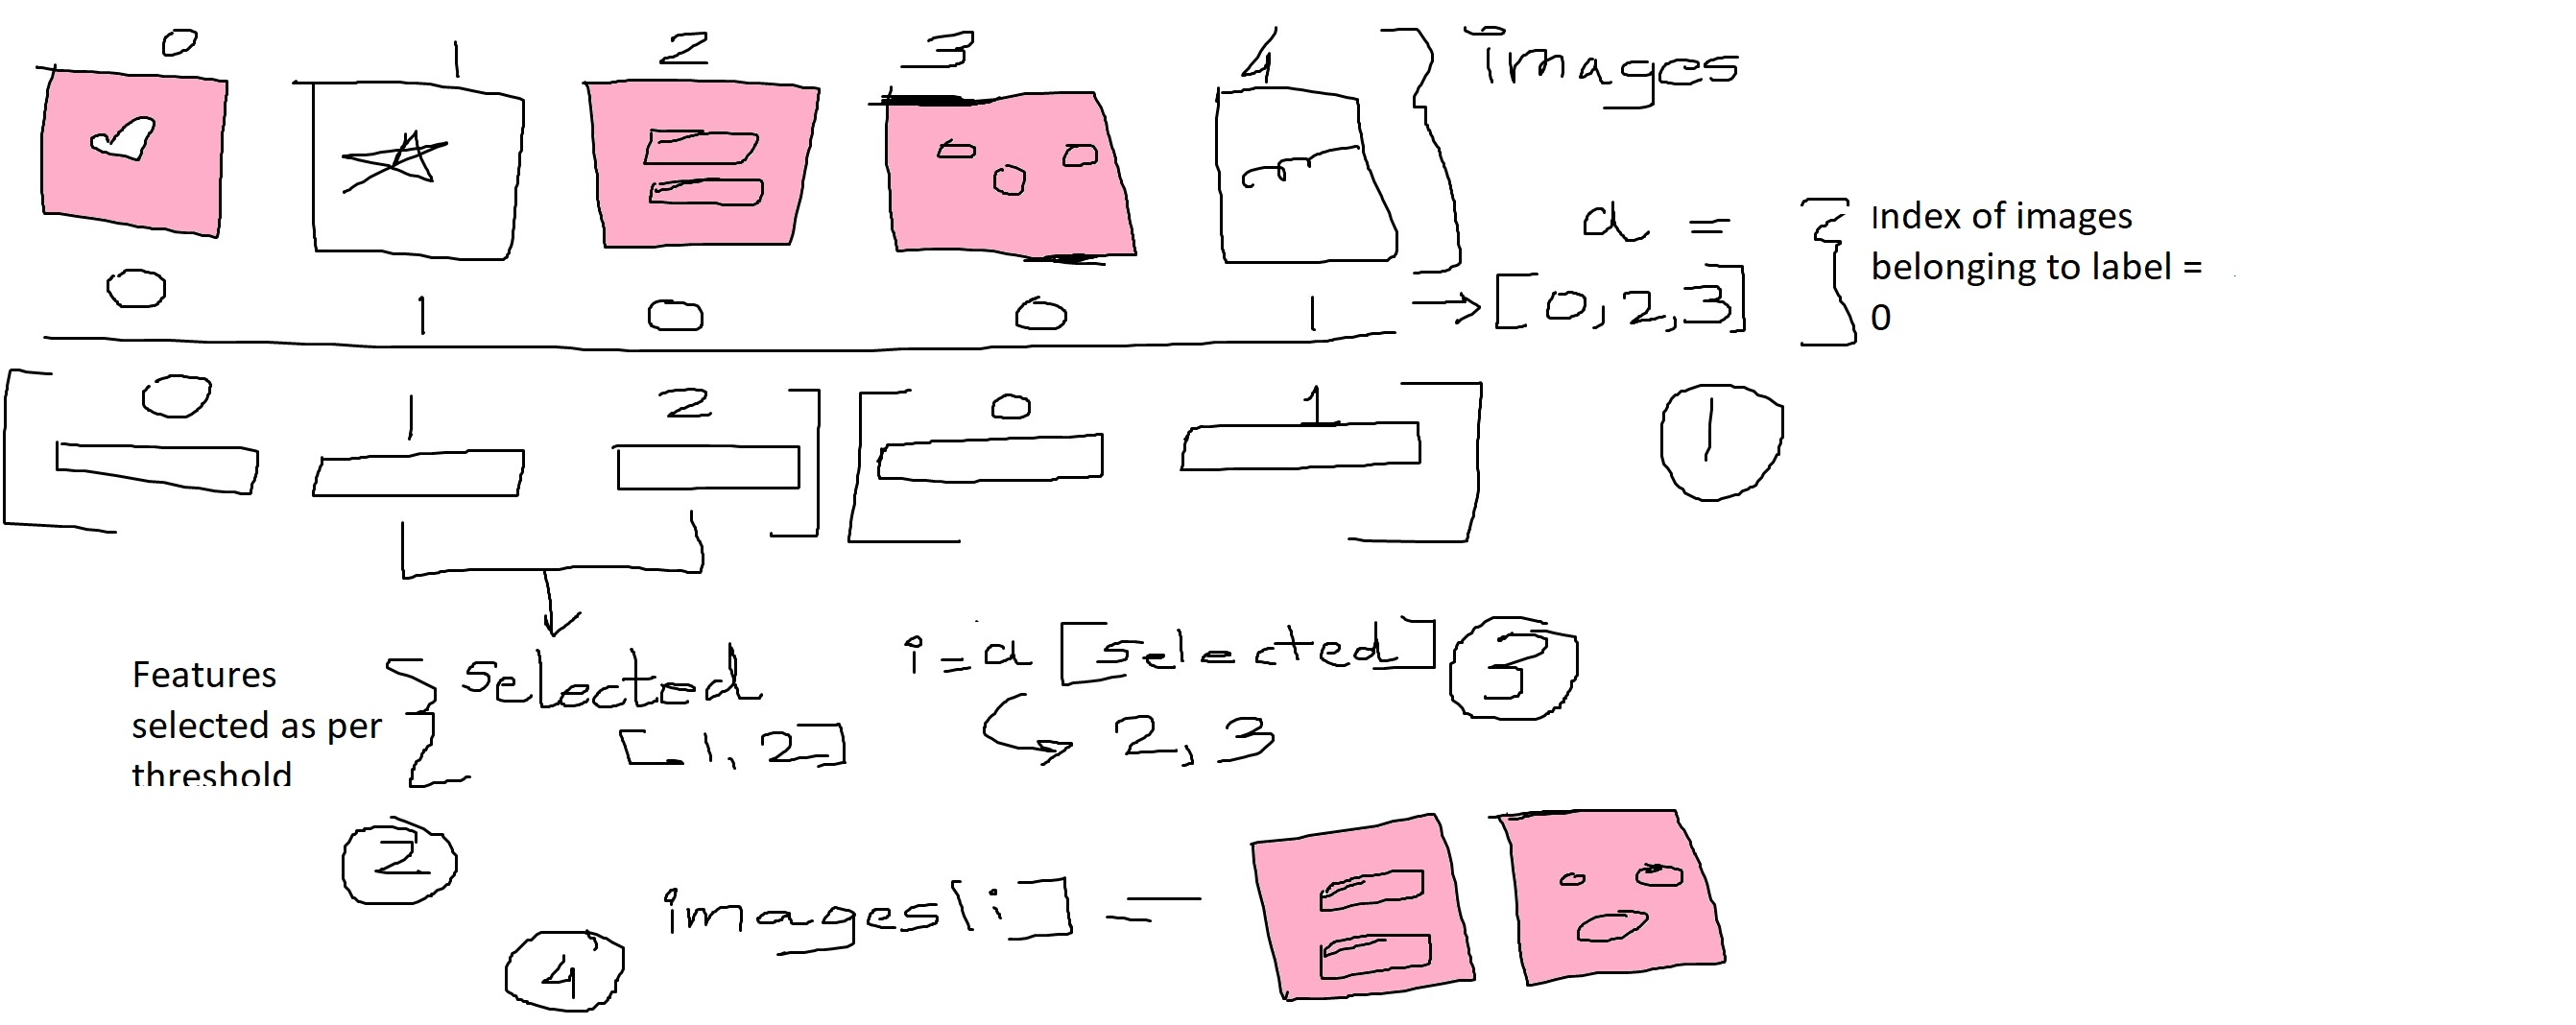

In [29]:
# get the indices of the feature maps from first center, selected using the threshold . 
selected_class1_index = np.asarray(np.where(features_center_1 >= 0.995))[0,:]
# get the indices of the images belonging to the first center
label0_index = np.asarray(np.where(kmeans.labels_ == 0))[0,:]

print(selected_class1_index)
print(label0_index)
print(label0_index[selected_class1_index])

# get the images
rivers_1 = X_train[list(label0_index[selected_class1_index])]


[  0   1   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  24  25  26  27  28  29  30  31  33  34  35  36  37  38
  39  41  42  43  44  45  46  48  49  50  51  54  55  56  57  58  59  60
  61  62  63  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79
  80  81  82  83  84  85  86  88  89  90  91  92  93  94  95  96  97  98
  99 100 101 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153
 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171
 172 173 174 176 177 178 179 180 181 182 184 185 186 187 188 189 190 191
 192 193 194 195 196 198 199 201 202 203 204 205 206 207 208 209 210 211
 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229
 230 231 232 233 234 236 237 238 239 240 241 242 244 246 247 248 249 250
 251 252 253 254 255]
[  1   3   5   6   8  11  15 

In [30]:
# visualize 
fig1, axes1 = plt.subplots(200,4, figsize=(20, 700))
fig1.suptitle('Rivers in cluster 0 visualization',y=1.0,fontsize=20,ha='center')
ax1 = axes1.ravel()
rivers = rivers_1[:,:,:,1]
for i in range(0,len(rivers_1)):
    river_array = rivers[i]
    ax1[i].imshow(river_array)

for a in ax1:
        a.set_axis_off()
plt.tight_layout()
plt.show()  

In [31]:
# get the indices of the feature maps from second center, selected using the threshold . 
selected_class2_index = np.asarray(np.where(features_center_2 >= 0.995))[0,:]
# get the indices of the images belonging to the second center
label1_index = np.asarray(np.where(kmeans.labels_ == 1))[0,:]

print(selected_class2_index)
print(label1_index)
print(label1_index[selected_class2_index])

# get the images
rivers_2 = X_train[list(label1_index[selected_class2_index])]


[ 0  1  2  3  4  6  9 12 18 19 20 23 24 26 27 30 31 33 34 35 39 40 41 42
 44 47 48 51 52 53 54 55 60]
[  0   2   4   7   9  10  12  13  14  24  28  29  31  32  36  42  45  50
  52  55  87  92  93  97 111 113 121 123 125 129 131 154 175 178 179 185
 195 198 209 210 215 222 225 233 235 239 240 246 261 263 267 272 289 292
 293 294 297 298 299 304 309]
[  0   2   4   7   9  12  24  31  52  55  87  97 111 121 123 131 154 178
 179 185 210 215 222 225 235 246 261 272 289 292 293 294 309]


In [32]:
fig2, axes2 = plt.subplots(200,4, figsize=(20, 700))
fig2.suptitle('Rivers in cluster 1 visualization',y=1.0,fontsize=20,ha='center')
ax2 = axes2.ravel()
rivers = rivers_2[:,:,:,1]
for i in range(0,len(rivers_2)):
    river_array = rivers[i]
    ax2[i].imshow(river_array)

for a in ax2:
        a.set_axis_off()
plt.tight_layout()
plt.show()  

### Step 4 : 
Fine-tune the deep learning module on reliable samples using pseudo labels given by the clusters. 

In [33]:
# Create the dataset
# get only the data which matches features which 
print(rivers_1.shape)
print(rivers_2.shape)

x_train = list(rivers_1)
y_label = list(np.zeros(len(rivers_1)))

for each in rivers_2:
        x_train.append(each)
        y_label.append(1)
        
x_train = np.array(x_train)
y_label = np.array(y_label)
print(x_train.shape)
print(y_label)

(239, 64, 64, 3)
(33, 64, 64, 3)
(272, 64, 64, 3)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]


In [41]:
import random
rivers = list(rivers_2)
images = np.asarray(random.sample(rivers,10))

In [34]:
train = ImageDataGenerator()
training = train.flow(x_train,y_label,batch_size = 20 )
training

In [35]:
ucl_model.compile(loss="binary_crossentropy",optimizer="adam",metrics=['accuracy'])

In [36]:
ucl_model = ucl_model.fit(training,
                epochs = 20,
                steps_per_epoch=len(training))

Epoch 1/20
14/14 [==============================] - 5s 119ms/step - loss: 0.3621 - accuracy: 0.8787
Epoch 2/20
14/14 [==============================] - 1s 104ms/step - loss: 0.2469 - accuracy: 0.8824
Epoch 3/20
14/14 [==============================] - 1s 99ms/step - loss: 0.1806 - accuracy: 0.9191
Epoch 4/20
14/14 [==============================] - 1s 98ms/step - loss: 0.1306 - accuracy: 0.9522
Epoch 5/20
14/14 [==============================] - 1s 98ms/step - loss: 0.1039 - accuracy: 0.9632
Epoch 6/20
14/14 [==============================] - 1s 99ms/step - loss: 0.0851 - accuracy: 0.9743
Epoch 7/20
14/14 [==============================] - 1s 96ms/step - loss: 0.0697 - accuracy: 0.9816
Epoch 8/20
14/14 [==============================] - 2s 117ms/step - loss: 0.0620 - accuracy: 0.9816
Epoch 9/20
14/14 [==============================] - 1s 105ms/step - loss: 0.0574 - accuracy: 0.9816
Epoch 10/20
14/14 [==============================] - 1s 98ms/step - loss: 0.0481 - accuracy: 0.9926
Epoch

In [37]:
rivers = data['x_train']
clusters = data['y_label']

for cluster in range(0,len(np.unique(clusters))):
    output = '../data/UCL_Results/'+experiment+"/cluster_"+str(cluster)+"/"
    save_files(rivers[np.asarray(np.where(clusters == cluster))], output, matplotlib_image)

# save model
path = results + 'model'
data['model'].save(path)
# read model
mode = model.load_model(path)

NameError: name 'data' is not defined

## Code Refactor

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import image as matplotlib_image
import glob
import os
import cv2
from tensorflow.keras.layers import Flatten, Dense, Input, Lambda, Conv2D, MaxPooling2D
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, img_to_array
import tensorflow as tf
import numpy as np
from glob import glob
import os
from tensorflow.keras.models import Sequential
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.utils import shuffle
import re
import cv2
from sklearn.cluster import KMeans
from keras.models import Model
from numpy.linalg import norm

In [ ]:
# Data Pre-processing 

fracmaps_dir = '../data/frac_map'
frac_maps = os.listdir(fracmaps_dir)
timeseries_dir = '../data/time_series'
time_series = os.listdir(timeseries_dir)

total_maps = len(frac_maps) # 26754
total_ts = len(time_series) # 26754
print("total_maps len is ", total_maps, "total_ts len is ", total_ts)

# read fraction map and time series into img arrays
for i in range(0, total_maps):
    fm = frac_maps[i]
    frac_maps[i] = np.load(os.path.join(fracmaps_dir, fm), allow_pickle=True)
    ts = time_series[i]
    time_series[i] = np.load(os.path.join(timeseries_dir, ts), allow_pickle=True)
    

print(frac_maps[0].shape) ## (1,64,64)
print(time_series[0].shape) ## (442, 1)


# 2. Read all the river fraction maps in the fm_rivers and river time series in the ts_rivers array

ID_labels = '../label_info/all_IDs_labels.npy'
ID_labels = np.load(ID_labels, allow_pickle=True)

# extract river from fraction maps and time series maps
river_ids = np.where(ID_labels==3)[0]
print(river_ids.shape) # 317
fm_rivers = []
ts_rivers = []
pre = 'ID_'
fm_post = '_frac_map.npy'
ts_post = '_time_series.npy'

for sid in river_ids:
    fm_name = pre + str(sid) + fm_post
    ts_name = pre + str(sid) + ts_post
    fm_path = os.path.join(fracmaps_dir, fm_name)
    ts_path = os.path.join(timeseries_dir, ts_name)
    fm_rivers.append(np.load(fm_path, allow_pickle=True))
    ts_rivers.append(np.load(ts_path, allow_pickle=True))

fm_rivers = np.array(fm_rivers)
ts_rivers = np.array(ts_rivers)
print(fm_rivers.shape) # should be 317
print(ts_rivers.shape) # should be 317

# Reshape input dataset as required by resnet50v2

from skimage.transform import resize
im = np.reshape(fm_rivers,(317,64,64,1))
im = resize(im, (317,64,64,3))
im.shape
X_train =im

In [ ]:
def visualize(data, data_size, cols,title,fx,fy,dtype='graph'):
    if data_size > 0:
        rows = (data_size//cols) + 1
        fig, axes = plt.subplots(rows,cols, figsize=(fx,fy))
        fig.suptitle(title,y=1.0,fontsize=40,ha='center')
        ax = axes.ravel()
        for i in range(0,data_size):
            if dtype == 'image':
                ax[i].imshow(data[i])
            else:
                ax[i].plot(data[i])

        for a in ax:
                a.set_axis_off()
        plt.tight_layout()
        plt.show()   


In [ ]:
def save_files(data,folder,image):
    os.makedirs(folder, exist_ok=True)
    for i in range(0, len(data)):
        img_name = folder + str(i) + ".jpeg"
        image.imsave(img_name, data[i])


In [ ]:
def select_model():
    # Extract features of remote sensing imagery of water bodies and non-water bodies using a pre-trained deep learning architecture.
    resnet = ResNet50V2(include_top=False, pooling='avg', weights='imagenet',input_shape = (64,64,3),classes = 1)

    # ResNet model doesn't contain the flattened fully connected layers, so we add them separately.
    resnet.layers

    # ResNet model doesn't contain the flattened fully connected layers, so we add them separately.
    #print(resnet.summary()[-8])
    print(resnet.layers[-1].output)

    # ResNet model doesn't contain the flattened fully connected layers, so we add them separately.
    ucl_model = Sequential()
    ucl_model.add(resnet)
    ucl_model.add(Flatten())
    ucl_model.add(Dense(128, activation='relu'))
    ucl_model.add(Dense(1, activation='sigmoid')) #sigmoid is used because this is a binary classification.  
    # freeze resnet50 conv layers and keep only new layers for fine-tuning. 
    ucl_model.layers[0].trainable = False
    print(ucl_model.summary())
    return {'ucl_model':ucl_model}   

In [ ]:
def step1(ucl_model):
    ucl_classes = ucl_model.predict(X_train)
    # classification results for binary classification of rivers, using imagenet weights
    print("Classes predicted by UCL Model are : ", str(ucl_classes[:10]))
    return {'predicted_classes':ucl_classes}

In [ ]:
def step2(ucl_model,plt,tot_clusters):
    # Step 2:
    # Create two clusters on the extracted features of remote sensing imagery, assigning them pseudo-labels of 'static rivers' and 'may meander rivers'

    # Kmeans
    # The images are classified into clusters based on similarity of pixel values. Each image is assigned a cluster label value given by kmeans.labels_. So kmeans.labels_ is an array of length 26754 as there are 26754 images in the training set.
    # The input to kmeans comes from the following layer which have imagenet weights after step 1.

    print("Layer type: ", ucl_model.layers[-3])
    print("Layer details: ",ucl_model.layers[-3].output)

    # create a new model to extract the features from ucl_model. This is the actual input to kmeans.

    model_features= Model(inputs=ucl_model.inputs, outputs=ucl_model.layers[-3].output)
    features = model_features.predict(X_train)  
    print(features.shape[0]) #317
    
    visualize(features,10,3,'Feature Visualization',*(20,20))

    # Initialize the class object
    kmeans = KMeans(n_clusters=tot_clusters)

    # Fit kmeans to the labels of clusters.
    kmeans = kmeans.fit(features)

    print("All Kmeans labels: ", kmeans.labels_)
    print("Kmeans cluster centers: ", kmeans.cluster_centers_)

    # filter rows of original data
    for i in range(0,tot_clusters) : 
        print("Total number of rivers in cluster",i,": ",features[kmeans.labels_==i].shape) 
        name = 'Features in Cluster '+str(i)
        visualize(features[kmeans.labels_==i][:10],10,3,name,*(20,20))   
        
    return {'cluster_centers':kmeans.cluster_centers_,'kmeans_labels':kmeans.labels_,'features':features}


In [ ]:
# test block
y_label =[]
for center in range(0,3):        
    y_label = y_label + [center]*10
type(y_label)

In [ ]:
def step3(centers, features, kmeans_labels, tot_clusters, selection_threshold):
    # Step 3 : 
    # From each cluster, select the reliable images using the UCL based selection operation. 
    # Select all features that are at a distance λ from the centroid of the cluster. The parameter λ is a constant value 
    # that can be adjusted according to the requirement. We have used λ = 0.85 after empirical evaluations.  
    # The closest feature vector to the centroid is considered as a centroid feature vector. 
    # We calculate the similarity between a specific feature vector fi belonging to a cluster k and the centroid feature vector fk using the inner product. 
    # If the calculated similarity is greater than the λ, the sample of the considered feature vector is declared as a reliable sample and the cluster label is considered as the pseudo sample label for the next training cycle.  
    # The number of extracted reliable samples vary at every iteration of fine tuning. 

    # calculate cosine similarity 
    
    feature_centers = []
    
    for cluster in range(0,tot_clusters):
        label_i = features[kmeans_labels== cluster]
        dot_product = np.dot(centers[cluster],label_i.T) #(1,2048).(2048,len(labels0))
        normalize_product = norm(centers[cluster])*norm(label_i,axis=1)
        center_i = dot_product/normalize_product
        print("Similarity to centroid ",cluster ,":  ",center_i[0:3])
        feature_centers.append(center_i)
    
    # printing the size of all clusters after selecting using threshold.
    for cluster in range(0,tot_clusters):
        # get selected features
        training_class_i = center_i[center_i >= selection_threshold]
        print("Total features selected for centroid",cluster,": ",training_class_i.shape)

    # Below is probably the most complicated cell in this entire notebook.
    x_train = []
    y_label = []
    
    for center in range(0,tot_clusters):        
        # get the indices of the feature maps from first center, selected using the threshold . 
        selected_class_index = np.asarray(np.where(feature_centers[center] >= selection_threshold))[0,:]
        # get the indices of the images belonging to the first center
        label_index = np.asarray(np.where(kmeans_labels == center))[0,:]

        print("Indices belonging to cluster ",center,": ",label_index)
        print("Indices selected for fine-tuning: ", selected_class_index)
        print("Indices of the images to be sent to model: ", label_index[selected_class_index])
        
        # get the images
        rivers = X_train[list(label_index[selected_class_index])]
        title = "Rivers in cluster"+str(center)
        x_train = x_train + list(rivers)
        y_label = y_label + [center]*len(rivers)
        visualize(rivers[:,:,:,1], rivers.shape[0],4,title,*(30,600),'image')
        
    
    return {'x_train':x_train,'y_label':y_label}


In [ ]:
def step4(ucl_model, x_train, y_label,train_epochs):
    # Step 4 : 
    # Fine-tune the deep learning module on reliable samples using pseudo labels given by the clusters. 

    # Create the dataset
    x_train = np.array(x_train)
    y_label = np.array(y_label)
    print(x_train.shape)
    print(y_label.shape)

    train = ImageDataGenerator()
    training = train.flow(x_train,y_label,batch_size = 20 )
    print(training)

    ucl_model.compile(loss="binary_crossentropy",optimizer="adam",metrics=['accuracy'])
    history = ucl_model.fit(training,
                    epochs = train_epochs,
                    steps_per_epoch=len(training))
    
    return ucl_model

# Experiment 1

In [ ]:
def run_ucl(ucl_model,plt,clusters,threshold,train_epochs) :
    kmeans_results = step2(ucl_model,plt,clusters)
    centers = kmeans_results['cluster_centers']
    features = kmeans_results['features']
    kmeans_labels = kmeans_results['kmeans_labels']
    selected_images = step3(centers,features, kmeans_labels,clusters, 0.75)
    ucl_model = step4(ucl_model, selected_images['x_train'], selected_images['y_label'])

In [ ]:
# experiment 0 : retrain the model for 10 iterations. 
# run on test dataset
def exp0(ucl_model,plt,clusters,threshold,train_epochs,test_data):
    for i in range(0,10):
        run_ucl(ucl_model,plt,clusters,threshold,train_epochs)
